# Excercise 2

In Excercise 1, we computed the LDA for a multi-class problem, the IRIS dataset. In this excercise, we will now compare the LDA and PCA for the IRIS dataset.

To revisit, the iris dataset contains measurements for 150 iris flowers from three different species.

The three classes in the Iris dataset:
1. Iris-setosa (n=50)
2. Iris-versicolor (n=50)
3. Iris-virginica (n=50)

The four features of the Iris dataset:
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm

<img src="iris_petal_sepal.png">



In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import pi
from sklearn.naive_bayes import GaussianNB
import math

### Importing the dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'Class']
dataset = pd.read_csv(url, names=names)

dataset.tail()

,sepal-length,sepal-width,petal-length,petal-width,Class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


### Data preprocessing

Once dataset is loaded into a pandas data frame object, the first step is to divide dataset into features and corresponding labels and then divide the resultant dataset into training and test sets. The following code divides data into labels and feature set:

In [3]:
X = dataset.iloc[:, 0:4].values
y = dataset.iloc[:, 4].values

The above script assigns the first four columns of the dataset i.e. the feature set to X variable while the values in the fifth column (labels) are assigned to the y variable.

The following code divides data into training and test sets:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Feature Scaling

We will now perform feature scaling as part of data preprocessing too. For this task, we will be using scikit learn `StandardScalar`.

In [5]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Write your code below

Write your code to compute the PCA and LDA on the IRIS dataset below.

In [6]:
class_string = np.unique(y)

def encode_y(y):
    classes = np.unique(y)
    for i in range(len(classes)):
        y = np.where(y == classes[i], int(i), y)
    return y
  
y_train = encode_y(y_train).astype(int)
y_test = encode_y(y_test).astype(int)
y = encode_y(y).astype(int)

In [7]:
# Calculating covariance of an input matrix
def calc_cov_matrix(X_input):
    n_samples = np.shape(X_input)[0]
    cov_matrix = np.array((1 / (n_samples-1)) * (X_input - X_input.mean(axis=0)).T.dot(X_input - X_input.mean(axis=0)))

    return cov_matrix

In [8]:
### WRITE YOUR CODE HERE ####

class LDA:
    
    def _mean(self, X, y):
        
        means = []
        classes = np.unique(y)
        
        for i in range(len(classes)):
            x_ = X[np.argwhere(y == classes[i])[:,0]]
            means.append(x_.mean(axis=0))
            
        return np.array(means)
    
    def _cov(self, X, y):
        
        covs = []
        classes = np.unique(y)
        
        for i in range(len(classes)):
            x_ = X[np.argwhere(y == classes[i])[:, 0]]
            covs.append(calc_cov_matrix(x_))
            
        return np.array(covs)
    
    # Calculates the weights
    def fit(self, X, y, k=2):
        
        classes = np.unique(y)
        means = self._mean(X, y)
        covs = self._cov(X, y)
                
        X_mean = X.mean(axis=0)
        
        class_mean_diff = []
        
        for i in range(len(classes)):
            x_ = X[np.argwhere(y == classes[i])[:,0]]
            class_mean_diff.append(len(x_) * (x_.mean(axis=0) - X_mean).reshape(-1,1) @ (x_.mean(axis=0) - X_mean).reshape(-1,1).T)
        
        class_mean_diff = np.array(class_mean_diff)
        
        SW = np.round(np.sum(covs, axis=0).astype(float), 3)
        SB = np.round(np.sum(class_mean_diff, axis=0).astype(float), 3)
        
        eigvals, eigvecs = np.linalg.eig(np.linalg.pinv(SW).dot(SB))       
        
        # Getting the eigenvectors with the maximum eigenvalue.
        idx = eigvals.argsort()[::-1]
        eigvals = eigvals[idx][:k]
        self.weights = np.atleast_1d(eigvecs[:, idx])[:, :k]
                
        self.model = GaussianNB(priors=None)
        self.model.fit(X @ self.weights, y)
        
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def get_scores(self, X, y):
        x_ = (X @ self.weights).astype(float)
        return self.model.score(x_, y)
    
    def transform(self, X):
        return X @ self.weights

In [9]:
def PCA(X, k=2):
    
    cov = calc_cov_matrix(X)
    eigvals, eigvecs = np.linalg.eig(cov)

    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx][:k]
    weights = np.atleast_1d(eigvecs[:, idx])[:, :k]

    return X @ weights

In [10]:
model_lda = LDA().fit(X_train, y_train)
x_train_lda = model_lda.transform(X_train)
x_train_pca = PCA(X_train)

In [11]:
print("Training Accuracy: {}".format(model_lda.get_scores(X_train, y_train) * 100))
print("Testing Accuracy: {}".format(model_lda.get_scores(X_test, y_test) * 100))

Training Accuracy: 97.5
Testing Accuracy: 100.0


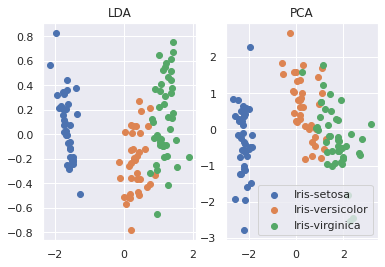

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)


classes = np.unique(y_train)
colors = ("r", "g", "b")

for i in range(len(classes)):
    ax1.scatter(x_train_lda[np.argwhere(y_train == i)[:, 0],0], x_train_lda[np.argwhere(y_train == i)[:, 0],1], label=class_string[i])
    ax2.scatter(x_train_pca[np.argwhere(y_train == i)[:, 0],0], x_train_pca[np.argwhere(y_train == i)[:, 0],1], label=class_string[i])
ax1.set_title("LDA")
ax2.set_title("PCA")

plt.legend()
plt.show()

# Observation

LDA visibly reduces the between class scatter, creating more compact points for each class. As a result, the classes are better separated in LDA (slightly) than PCA. Note that this is when we use a 2-dimensional feature space. 